In [1]:
import pandas as pd

import numpy as np
from scipy import stats
from statsmodels.stats.contingency_tables import StratifiedTable

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

%config IPCompleter.greedy = True

In [2]:
sns.set(
    font_scale = 2,
    style      = 'whitegrid',
    rc         = {'figure.figsize':(20,7)}
)

In [3]:
df = pd.read_csv('/Users/askhabaliev/Desktop/analysis/hw_aa.csv', sep=';', index_col=0)
df.head()

,experimentVariant,category,mobileBrandName,version,operatingSystem,region,purchase
1,0,mobile,Huawei,3.8.2.0,ANDROID,Moscow,0
2,0,mobile,NaN,3.8.2.0,ANDROID,Krasnodar Krai,0
3,1,tablet,Apple,2.8.0,IOS,Moscow Oblast,0
4,1,mobile,Xiaomi,3.8.2.0,ANDROID,Rostov Oblast,0
5,1,mobile,Samsung,3.8.2.0,ANDROID,Republic of Tatarstan,0


In [4]:
# Проверим, есть ли пропущенные значения?

df.isna().sum()

experimentVariant       0
category                0
mobileBrandName      3729
version                 0
operatingSystem         0
region               1801
purchase                0
dtype: int64

In [5]:
# Удалим пропущенные значения

df = df.dropna()

In [6]:
# Разобьем на 2 группы

df_0 = df[df.experimentVariant == 0]
df_1 = df[df.experimentVariant == 1]

  0%|          | 0/1000 [00:00<?, ?it/s]

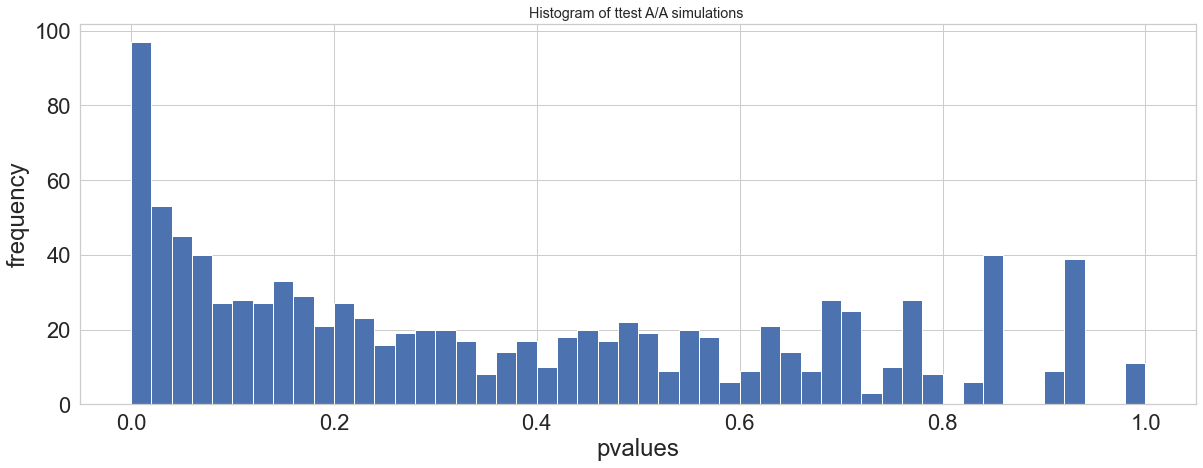

0.174

In [7]:
# Проведем АА тест, с целью сравнить 2 наших группы перед тем как применять АВ тест

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df_0['purchase'].sample(n_s, replace = False).values
    s2 = df_1['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Кол-во выборок со значимым различием превышет 5%?

sum(np.array(res) < 0.05) / simulations

Количество значимых различий между группами превышет 17%. Попробуем разобраться в чем причина такого сильного различия.

In [8]:
df \
    .groupby(['experimentVariant', 'operatingSystem']) \
    .agg({'purchase': 'mean', 'category': 'count'}) \
    .rename(columns={'category': 'count_users'})

purchase  count_users
experimentVariant operatingSystem                       
0                 ANDROID          0.066085       128138
                  IOS              0.016765        53027
1                 ANDROID          0.066857       128199
                  IOS              0.051513        53404

Разбив группы по OS, мы видим, что количество в группах примерно одинаково, но значение ключевого показателя(purchase) у IOS пользователей отличается в 5 раз.

In [9]:
#Удалим пользователей IOS из выборки и повторим эксперимент.

group_0 = df[(df.experimentVariant == 0) & (df.operatingSystem != 'IOS')]
group_1 = df[(df.experimentVariant == 1) & (df.operatingSystem != 'IOS')]

  0%|          | 0/1000 [00:00<?, ?it/s]

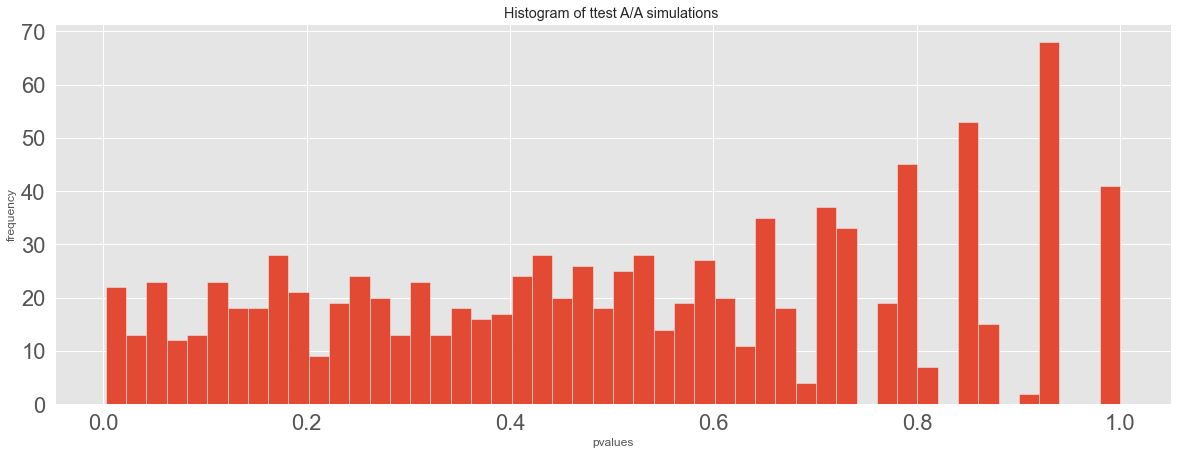

0.046

In [11]:
res = []

for i in tqdm(range(simulations)):
    s1 = group_0['purchase'].sample(n_s, replace = False).values
    s2 = group_1['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) < 0.05) / simulations

Убрав из выборки пользователей IOS, мы сильно приблизили наши группы к равенству. Попробуем понять, почему у пользователей IOS такая разница...

In [12]:
df[(df.operatingSystem == 'IOS')] \
    .groupby(['experimentVariant', 'version']) \
    .agg({'purchase': 'mean', 'category': 'count'}) \
    .rename(columns={'category': 'count_users'})

purchase  count_users
experimentVariant version                       
0                 2.8.0    0.000000        41137
                  2.9.0    0.074769        11890
1                 2.7.0    0.000000            2
                  2.8.0    0.045730        41417
                  2.9.0    0.071506        11985

Как мы видим, большая часть пользователей IOS(из нашей выборки) использует версию IOS 2.8.0, но в нулевой группе показатель purchase равен нулю.